Puedes utilizar estos entornos para ejecutar el código (si lo haces así, tienes que subir los datos)

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

## REDES RECURRENTES (aplicado a series temporales)

Adaptado de [Hands on Machine Learning for Python](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch15.html#cnn_chapter), utilizando lo aprendido en las sesiones de series temporales

Requisitos y recomendaciones:  
* Python 3.7 o superior
* Tensorflow 2.8 o superior
* Es preferible utilizar un entorno con GPU (si se quiere probar la parte LSTM y GRU mejor con Nvida, ya que Keras emplea cuRNN que es una mejora basada en CUDA para Nvidia), por ejemplo Colab de Google

In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 15.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from pmdarima.arima import ARIMA, auto_arima
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from packaging import version
assert version.parse(tf.__version__) >= version.parse("2.8.0")

Algunas preconfiguraciones para hacer más "visibles" los gráficos

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### El problema: Predecir el uso del transporte público en Chicago

Como ya hicimos al ver las series temporales con modelos tradicionales, vamos a utilizar los datos diarios de utilización de autobuses y tren de la ciudad de Chicago. Te recuerdo que están extraídos de su portal de datos públicos, y te recomiendo que te des una vuelta por él. Chicago es una de las ciudades más Smart del mundo y llevan recogiendo datos de diversos temas desde hace mucho tiempo... [Chicago's Data Portal](https://data.cityofchicago.org/)


Cargemos y preparemos los datos. Recuerda en series temporales conviene convertir a datatime las fechas y usarlas como índices.

In [4]:
import pandas as pd

DATA_PATH = "./CTA_-_Ridership_-_Daily_Boarding_Totals.csv"
df = pd.read_csv(DATA_PATH, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").set_index("date")
# Hacemos un poco de limpieza
df = df.drop("total", axis=1)  # No se necesita el total (viajes en bus+tren)
df = df.drop_duplicates()  # Quitamos duplicados, hay varios

Como en cualquier otro dataset echamos un vistazo, pero además siendo una serie recuerda que es importante descomponerla y analizar su estacionariedad.

In [5]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


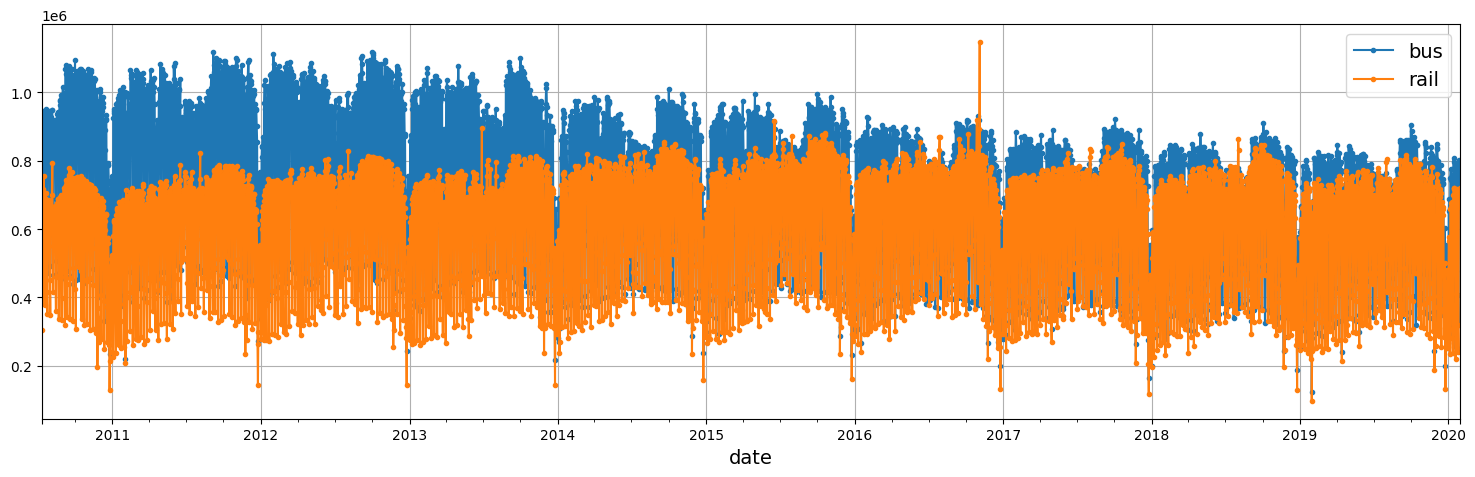

In [6]:
df["2010-07-11":"2020-01-31"].plot(grid = True, marker = ".", figsize = (15,5) ) # Al hacer la fecha el indice podemos utilizarla facilmente como índice
plt.tight_layout()

Como recordarás de la unidad de series temporales... ok, vale, no lo recuerdas, pero te lo recuerdo yo... estas series tenían tendencia y dos tipos de estacionalidad (semanal y anual)

Para ver la estacionalidad semanal, pintábamos la serie y su desplazada una semana:

<Axes: xlabel='date'>

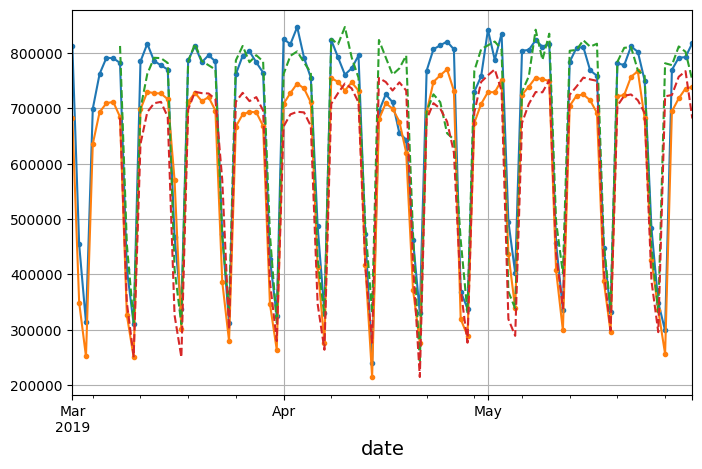

In [7]:
comienzo = "2019-03"
fin = "2019-05"

fig, axs = plt.subplots(1, 1, figsize=(8, 5))
df[comienzo:fin].plot(ax=axs, legend=False, marker=".")  # original time series
df[comienzo:fin].shift(7).plot(ax=axs, grid=True, legend=False, linestyle="--")  # lagged

Se ve claramente como se superponen casi perfectamente, lo que además nos invitaba a generar un modelo "naive" como baseline. Pero en este caso haremos uso de un modelo SARIMA como baseline. Antes descompogamos la serie mensualizandola (calculando medias por meses) para ver la estacionalidad anual:

(Recordemos que podíamos hacer descomposicion multiplicativa o aditiva)

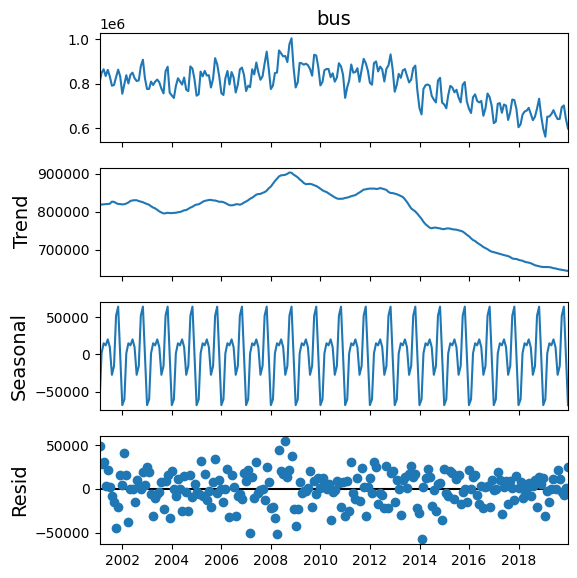

In [8]:
df_mensualizada = df.resample("M").mean(numeric_only= True)
result_add = seasonal_decompose(df_mensualizada["bus"][:"2019-12-31"], model = 'additive', extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
result_add.plot();

Se puede observar la repetición del patrón anual.

Además también existe una tendencia clara. En definitiva no son series estacionarias, aunque por teminar de recordar vamos a hacer el test de Dickey-Fuller aumentado o ADF test:

In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['bus'].values)
result[1]

np.float64(0.11251437221393645)

El p-value es mayor de 0.05 así que no podemos rechazar la hipótesis nula de no estacionariedad (como ya esperábamos)

En definitiva, si estuvieramos intentando crear un modelo predictivo de la serie temporal, utilizaríamos un SARIMA con diferenciación (d distinto de 0) y con estacionalidad.

De hecho, empleemos como baseline el SARIMA que vimos en la unidad de series temporales, primero prediciendo a 14 días vista:

In [10]:
origin, today = "2019-01-01", "2019-05-31"
#origin,today = "2018-01-01", "2018-12-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
rail_series_valid = df.loc["2019-06":"2019-06"]["rail"].asfreq("D")

model = ARIMA(order=(1,0, 1),
        seasonal_order=(0, 1, 1, 7)) # Orden: P,D,Q,s -> s= 7 porque recuerda que era el periodo semanal tan pronunciado
model = model.fit(rail_series)
y_pred = model.predict(1)  # returns 427,758.6

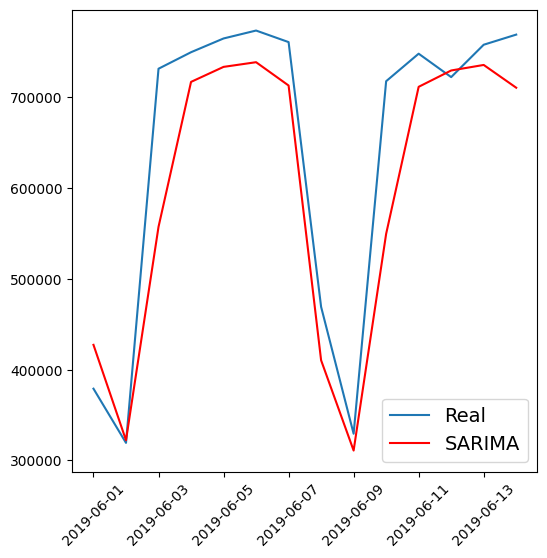

In [11]:
y_valid = rail_series_valid.iloc[:14]
y_pred = model.predict(14) # dos semanas
plt.plot(y_valid, label = "Real")
plt.plot(y_pred,color='red', label = "SARIMA")
plt.xticks(rotation = 45)
plt.legend()

In [12]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)

RMSE: 73503.55777660896
MAPE: 8.195451769682629


Muy bien ahí tenemos nuestro baseline, ahora veamos que tal lo hacemos usando redes neuronales

***

### Con MLPs o Redes densas (DNN, deep neural networks)

Las redes recurrentes además de su complejidad para "visualizarlas" mentalmente y la propia de tener que configurarlas como cualquier otra capa de DL, añaden la farragosa tarea de preparar los dataset de entrada... Tal como vimos al hablar de entrenamiento en las sesiones teóricas.

Entre otras cosas porque ahora la red espera batches de secuencias con multiples posibilidades en los targets...


Por ejemplo, si tuvieramos una serie temporal de ingresos de una empresa con valores diarios tal como:

[12500, 3500, 1234, 111000, 2345, 8889, 12567]

Y quisieramos predecir el día siguiente con los tres días anteriores tendríamos que construir el siguiente dataset:

[12500,3500,1234], target: [111000]  
[3500,1234,111000], target: [2345]  
[1234,111000,2345], target: [8889]  
[111000,2345,8889], target: [12567]  

Donde ahora cada fila es una instancia y una secuencia con su target

Para poder preparar los batches y el dataset de entrenamiento a partir del dataframe con los datos, Keras nos da ciertas "facilidades"

In [13]:
# Al igual que teniamos el "generador" de imágenes sintéticas, tensorflow tiene un generador de datasets para series temporales que nos viene perfecto (https://keras.io/api/preprocessing/timeseries/)

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2,
    shuffle = False # Este parametro permite controlar que mezclemos las secuencias (como en el ejemplo del surf en las sesiones teóricas)
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

Ha creado dos batches, el primero con las dos posibles primeras secuencias posibles de 3 intervalos [0,1,2] y [1,2,3] y el segundo con una sóla secuencia porque no tiene más datos para generarla: [2,3,4]

In [14]:
my_series = [12500, 3500, 1234, 111000, 2345, 8889, 12567]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2,
    shuffle = True # Este parametro permite controlar que mezclemos las secuencias (como en el ejemplo del surf en las sesiones teóricas)
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 12500,   3500,   1234],
         [  1234, 111000,   2345]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([111000,   8889], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[  3500,   1234, 111000],
         [111000,   2345,   8889]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 2345, 12567], dtype=int32)>)]

Hacemos tres datasets: entrenamiento, validación y test y aplicamos "normalización" casera, aunque al ser una serie univariante (sólo vamos a usar por ahora una única característica) no debería afectarle

In [15]:
df["rail"].max()

1146516

In [16]:
df["bus"].max()

1211992

In [17]:
rail_train = df["rail"]["2016-01":"2019-05"] / 1e6
rail_valid = df["rail"]["2019-04-06":"2019-06"] / 1e6 # Para usar Junio como validación tenemos que empezar 56 días antes
rail_test = df["rail"]["2019-07":] / 1e6

De los dataframes pasamos a los datasets preparados para entrenar las capas recurrentes usando el comentado timeseries_dataset_from_array y construyendo el dataset de entrada para una predicción al día siguiente después de 56 días (es decir 8 semanas) (esta es una selección arbitraría y podríamos haber empleado otro criterio, pero son más o menos dos meses).

In [18]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
) # Creará batches de 32 secuencias formadas por 56 días seguidos y target el 57 y a su vez esas secuencias estarán desordenadas (no son 56 días y luego los 56 días desplazados una vez...)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)
# En cambio la validación son secuencias consecutivas (es decir los 56 primeros días de 2019 y predigo el 57, los días 1 a 57 y target el 58, etc)

In [19]:
list(train_ds)[14]

(<tf.Tensor: shape=(32, 56), dtype=float64, numpy=
 array([[0.427874, 0.293056, 0.759849, ..., 0.714672, 0.689517, 0.65087 ],
        [0.764033, 0.75475 , 0.421193, ..., 0.751951, 0.782134, 0.782591],
        [0.741459, 0.729461, 0.401568, ..., 0.736639, 0.76118 , 0.757859],
        ...,
        [0.718899, 0.7113  , 0.590674, ..., 0.301294, 0.711535, 0.727732],
        [0.404779, 0.304418, 0.690624, ..., 0.736258, 0.755558, 0.745485],
        [0.861954, 0.831628, 0.521622, ..., 0.806181, 0.813982, 0.838474]])>,
 <tf.Tensor: shape=(32,), dtype=float64, numpy=
 array([0.415919, 0.821158, 0.748983, 0.446049, 0.238356, 0.761469,
        0.731398, 0.374595, 0.770199, 0.437154, 0.402561, 0.74572 ,
        0.699928, 0.250724, 0.709023, 0.737976, 0.573542, 0.757102,
        0.784018, 0.740579, 0.347259, 0.713858, 0.758455, 0.722671,
        0.697758, 0.28927 , 0.572525, 0.763084, 0.79578 , 0.712714,
        0.427964, 0.847133])>)

In [20]:
list(valid_ds)[0]

(<tf.Tensor: shape=(30, 56), dtype=float64, numpy=
 array([[0.41414 , 0.276992, 0.754465, ..., 0.717681, 0.735508, 0.738322],
        [0.276992, 0.754465, 0.747311, ..., 0.735508, 0.738322, 0.379044],
        [0.754465, 0.747311, 0.731858, ..., 0.738322, 0.379044, 0.319334],
        ...,
        [0.750517, 0.437434, 0.338727, ..., 0.756023, 0.75888 , 0.757999],
        [0.437434, 0.338727, 0.72423 , ..., 0.75888 , 0.757999, 0.717591],
        [0.338727, 0.72423 , 0.738981, ..., 0.757999, 0.717591, 0.438017]])>,
 <tf.Tensor: shape=(30,), dtype=float64, numpy=
 array([0.379044, 0.319334, 0.731571, 0.749759, 0.764911, 0.773638,
        0.760907, 0.469189, 0.329388, 0.717811, 0.748133, 0.722333,
        0.758006, 0.769162, 0.419997, 0.319752, 0.684609, 0.747919,
        0.735207, 0.755009, 0.748258, 0.46889 , 0.314345, 0.694599,
        0.756023, 0.75888 , 0.757999, 0.717591, 0.438017, 0.473462])>)

In [21]:
rail_valid.iloc[:57]

,rail
date,
2019-04-06,0.414140
2019-04-07,0.276992
2019-04-08,0.754465
2019-04-09,0.747311
2019-04-10,0.731858
2019-04-11,0.746596
2019-04-12,0.731825
2019-04-13,0.417501
2019-04-14,0.215007


***


### Construyendo el modelo

Vamos a construir un modelo supersimple sin capa oculta, sólo una neurona sin función de activación (es decir una capa de salida de un modelo de regresión):

In [22]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"]) # ¿Por qué la Huber cómo función de pérdida?


Antes de entrenar, entendamos que estamos haciendo: Una regresión lineal de los 56 días anteriores al que quiero predecir, es parecido a hacer un ARIMA con p = 56, d = 0, q = 0

In [23]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.3503 - mae: 0.7274 - val_loss: 0.0062 - val_mae: 0.0869
Epoch 2/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0144 - mae: 0.1274 - val_loss: 0.0056 - val_mae: 0.0834
Epoch 3/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0089 - mae: 0.0978 - val_loss: 0.0059 - val_mae: 0.0799
Epoch 4/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0083 - mae: 0.0949 - val_loss: 0.0067 - val_mae: 0.0841
Epoch 5/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0069 - mae: 0.0849 - val_loss: 0.0061 - val_mae: 0.0804
Epoch 6/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0068 - mae: 0.0839 - val_loss: 0.0045 - val_mae: 0.0780
Epoch 7/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0065 - mae: 0.0814 - val_loss: 0.0041 - val_mae: 0.0706
Epoch 8/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0057 - mae: 0.0738 - val_loss: 0.0038 - val_mae: 0.0685
Epoch 9/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - los

In [24]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 7.6033e-04 - mae: 0.0302


30184.324830770493

Hmm, parece mucho mejor... ?verdad? Pues no exactamente, porque si te fijas esta validación es día a día (es decir no prediciendo con los datos hasta hoy los próximos 14 días, sino prediciendo cada uno de los próximos 30 días, los de junio de 2019 que es el validation set, con los 56 días anteriores a cada día). En sesiones posteriores veremos la comparación correcta con el baseline de SARIMA.

Por otro lado y aunque lo parezca, no hemos hecho uso del orden de los datos, es decir tal como hemos entrenado podríamos haber desordenado las secuencias internamente (cambiando el orden de la misma forma en todas, por ejemplo intercambiando el día 23 con el 47 y el 12 con el 2, etc) que hubiera salido el mismo resultado. No estamos teniendo en cuenta el orden y para eso introduciremos las redes recurrentes.

Pero antes de terminar un pequeño inciso para introducir la función de pérdida Huber (sí, si te has fijado bien es la que hemos usado):

### Función de pérdida Huber

La función de pérdida de Huber es una combinación de error cuadrático medio (MSE, por sus siglas en inglés) y error absoluto medio (MAE, por sus siglas en inglés), diseñada para ser robusta a outliers en los datos. La principal diferencia entre la pérdida de Huber y la MSE radica en cómo tratan los errores grandes:

**MSE (Mean Squared Error)**: Calcula el promedio de los cuadrados de los errores entre los valores predichos y los reales. Tiende a penalizar mucho los errores grandes, lo que puede llevar a una sensibilidad excesiva a outliers en el conjunto de datos.  

**Pérdida de Huber**: Es menos sensible a los outliers que MSE. Para errores pequeños, funciona como MSE, y para errores grandes, se comporta como MAE, haciendo que la pérdida sea lineal en vez de cuadrática con respecto a la diferencia entre el valor predicho y el real. Esto se logra mediante un (hiper)parámetro delta (δ), que define el umbral entre tratar un error como grande o pequeño.

#### ¿Cuándo usar la pérdida de Huber frente a la MSE?

La pérdida de Huber se prefiere sobre MSE en situaciones donde hay una expectativa de outliers en los datos, o cuando no se desea que los errores grandes dominen la función de pérdida. Es decir, si tu conjunto de datos incluye valores anómalos que podrían afectar negativamente el proceso de entrenamiento del modelo con MSE, la pérdida de Huber puede ofrecer un enfoque más equilibrado y robusto.

Por otro lado, MSE puede ser preferible en situaciones donde todos los errores se consideran igualmente importantes, y se desea penalizar más fuertemente los errores grandes para enfocarse en minimizar estos errores específicos durante el entrenamiento.

En nuestro caso podríamos haber empleado una MSE, pero como hay variaciones fuertes entre los años usamos una Huber, además por defecto delta (δ) vale 1, al haber normalizado al millón lo que estamos diciendo es que penalice más los errores superiores al millón (considerándolos como outliers y penalizándolos de forma cuadrática) y los errores inferiores al millón los considere equilibrados (pesándolos en términos absolutos). Si tu rango de valores es diferente tendrás que ajustar delta de forma adecuada.

***

## Using a Simple RNN

Ahora vamos a emplear una única capa con una única celda o neurona recurrente sencilla (el hidden_stat(t) = output(t-1) y hidden_state(0) = 0)
Es interesante darse cuenta de que la función de activación no es una relu es una tanh... ¿Por qué?

https://keras.io/api/layers/recurrent_layers/simple_rnn/

In [25]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [26]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500, patience = None):
    patience = int(epochs//10) if patience == None else patience # Si no nos dan "paciencia" el 10% de las épocas
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience= patience, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [27]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.6894 - mae: 1.1043 - val_loss: 0.0614 - val_mae: 0.3060
Epoch 2/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0589 - mae: 0.2876 - val_loss: 0.0275 - val_mae: 0.1561
Epoch 3/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0247 - mae: 0.1615 - val_loss: 0.0167 - val_mae: 0.1610
Epoch 4/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0195 - mae: 0.1700 - val_loss: 0.0161 - val_mae: 0.1541
Epoch 5/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0196 - mae: 0.1673 - val_loss: 0.0156 - val_mae: 0.1538
Epoch 6/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0187 - mae: 0.1657 - val_loss: 0.0152 - val_mae: 0.1522
Epoch 7/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0177 - mae: 0.1619 - val_loss: 0.0147 - val_mae: 0.1535
Epoch 8/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0176 - mae: 0.1645 - val_loss: 0.0143 - val_mae: 0.1503
Epoch 9/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - lo

102773.15974235535

Y ahora ya vamos a emplear una capa con 32 neurona y luego una capa densa que nos de la regresión, sin función de activación

In [28]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [29]:

fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0882 - mae: 0.2740 - val_loss: 0.0035 - val_mae: 0.0702
Epoch 2/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0058 - mae: 0.0730 - val_loss: 0.0019 - val_mae: 0.0393
Epoch 3/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0045 - mae: 0.0619 - val_loss: 0.0020 - val_mae: 0.0397
Epoch 4/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0042 - mae: 0.0582 - val_loss: 0.0015 - val_mae: 0.0377
Epoch 5/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0038 - mae: 0.0534 - val_loss: 0.0016 - val_mae: 0.0359
Epoch 6/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0034 - mae: 0.0503 - val_loss: 0.0014 - val_mae: 0.0381
Epoch 7/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0033 - mae: 0.0505 - val_loss: 0.0019 - val_mae: 0.0414
Epoch 8/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0033 - mae: 0.0486 - val_loss: 0.0013 - val_mae: 0.0351
Epoch 9/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - lo

23599.382489919662

Esto ya es otra cosa. Mejor que una capa con una sola neurona, veamos ahora (bueno en la siguiente sesión) como funciona con varias capas recurrentes.

***

### Deep RNNs

Hora de aplicar unas cuantas capas de recurrentes a ver si captan más patrones temporales y mejora nuestro regresor.

In [30]:
# Importante: ahora tengo que pasarle todos los valores de salida de cada elemento de la secuencia a las capas siguientes menos a la última, por eso return_sequence = True

tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [31]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0323 - mae: 0.2058 - val_loss: 0.0041 - val_mae: 0.0682
Epoch 2/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0068 - mae: 0.0832 - val_loss: 0.0033 - val_mae: 0.0543
Epoch 3/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0060 - mae: 0.0782 - val_loss: 0.0026 - val_mae: 0.0438
Epoch 4/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0053 - mae: 0.0680 - val_loss: 0.0024 - val_mae: 0.0447
Epoch 5/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0043 - mae: 0.0599 - val_loss: 0.0041 - val_mae: 0.0784
Epoch 6/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0060 - mae: 0.0786 - val_loss: 0.0022 - val_mae: 0.0389
Epoch 7/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0046 - mae: 0.0586 - val_loss: 0.0020 - val_mae: 0.0381
Epoch 8/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0040 - mae: 0.0548 - val_loss: 0.0021 - val_mae: 0.0402
Epoch 9/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - lo

28745.539486408234

### Series multivariantes

Pues como tenemos más series temporales que covarian con la de "rail", vamos a usarlas para hacer un modelo multivariante, parecido a usar ARIMAX o SARIMAX (aunque más potente)

In [32]:
df_mulvar = df[["bus", "rail"]] / 1e6  # Usaremos los datos de uso de autobus y tren (metro y tren elevado) y escalados igual que antes
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # Pero también podemos utilizar el tipo de día que es "mañana"
df_mulvar = pd.get_dummies(df_mulvar, dtype= float)  # siempre como número, así que le hacemos un one-hot-encoding

In [33]:
df_mulvar.head(5)

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0.0,0.0,1.0
2001-01-02,0.780827,0.501952,0.0,0.0,1.0
2001-01-03,0.824923,0.536432,0.0,0.0,1.0
2001-01-04,0.870021,0.550011,0.0,0.0,1.0
2001-01-05,0.890426,0.557917,1.0,0.0,0.0


In [34]:
mulvar_train = df_mulvar["2016-01":"2019-05"]
mulvar_valid = df_mulvar["2019-04-06":"2019-06"] # 56 días antes del 1 de Junio es el 6 de abril, todo para 2019
mulvar_test = df_mulvar["2019-07":]

In [35]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [36]:
# Num batches
print(len(list(train_mulvar_ds)))

38


Veamos que pinta tiene un batch cualquiera de los 38 batches

In [37]:
list(train_mulvar_ds)[23]

(<tf.Tensor: shape=(32, 56, 5), dtype=float64, numpy=
 array([[[0.763402, 0.76038 , 1.      , 0.      , 0.      ],
         [0.514092, 0.488429, 0.      , 1.      , 0.      ],
         [0.398108, 0.364979, 0.      , 0.      , 1.      ],
         ...,
         [0.74137 , 0.697126, 0.      , 0.      , 1.      ],
         [0.763384, 0.719511, 0.      , 0.      , 1.      ],
         [0.749315, 0.748046, 0.      , 0.      , 1.      ]],
 
        [[0.841494, 0.732495, 1.      , 0.      , 0.      ],
         [0.469539, 0.391597, 0.      , 1.      , 0.      ],
         [0.306896, 0.263073, 0.      , 0.      , 1.      ],
         ...,
         [0.859775, 0.741922, 0.      , 0.      , 1.      ],
         [0.878633, 0.760062, 0.      , 0.      , 1.      ],
         [0.882188, 0.764033, 0.      , 0.      , 1.      ]],
 
        [[0.426814, 0.429256, 0.      , 1.      , 0.      ],
         [0.359562, 0.330196, 0.      , 0.      , 1.      ],
         [0.84037 , 0.747181, 0.      , 0.      , 1.      

Y el último

In [38]:
list(train_mulvar_ds)[-1]

(<tf.Tensor: shape=(7, 56, 5), dtype=float64, numpy=
 array([[[0.775628, 0.735211, 1.      , 0.      , 0.      ],
         [0.472932, 0.441274, 0.      , 1.      , 0.      ],
         [0.35173 , 0.324959, 0.      , 0.      , 1.      ],
         ...,
         [0.71    , 0.702495, 0.      , 0.      , 1.      ],
         [0.737497, 0.726837, 0.      , 0.      , 1.      ],
         [0.725134, 0.727089, 0.      , 0.      , 1.      ]],
 
        [[0.827885, 0.734586, 0.      , 0.      , 1.      ],
         [0.841278, 0.737535, 0.      , 0.      , 1.      ],
         [0.815353, 0.726872, 0.      , 0.      , 1.      ],
         ...,
         [0.517493, 0.433603, 0.      , 1.      , 0.      ],
         [0.357643, 0.319046, 0.      , 0.      , 1.      ],
         [0.84061 , 0.743301, 0.      , 0.      , 1.      ]],
 
        [[0.770336, 0.745511, 0.      , 0.      , 1.      ],
         [0.765291, 0.780813, 0.      , 0.      , 1.      ],
         [0.721413, 0.762815, 1.      , 0.      , 0.      ]

In [39]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]), # Ojo al input shape
    tf.keras.layers.Dense(1)
])

In [40]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.2075 - mae: 0.4899 - val_loss: 0.0018 - val_mae: 0.0426
Epoch 2/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0036 - mae: 0.0647 - val_loss: 0.0020 - val_mae: 0.0551
Epoch 3/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0026 - mae: 0.0531 - val_loss: 8.1153e-04 - val_mae: 0.0291
Epoch 4/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0021 - mae: 0.0457 - val_loss: 5.9805e-04 - val_mae: 0.0231
Epoch 5/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018 - mae: 0.0417 - val_loss: 6.7738e-04 - val_mae: 0.0265
Epoch 6/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017 - mae: 0.0387 - val_loss: 5.6137e-04 - val_mae: 0.0208
Epoch 7/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - mae: 0.0381 - val_loss: 7.7218e-04 - val_mae: 0.0310
Epoch 8/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016 - mae: 0.0410 - val_loss: 6.4742e-04 - val_mae: 0.0265
Epoch 9/500
38/38 ━━━━━━━━━━━━━━

20072.301849722862

Hmm, ha mejorado (cosa que no logramos con los SARIMAX en su día), pero siempre con predicción a un día. En la siguiente sesión ampliaremos el horizonte temporal y ya compararemos con nuestro baseline inicial.

***

## Predecir varios intervalos temporales en el futuro

Pero al igual que hicimos con el autoarima, nos gustaría predecir no sólo al día siguiente sino los x días siguientes...

**Caso 1**: Predecir tipo ARIMA (seq2vec)

Como hacemos con el predict(num_intervalos) del autoarima (vamos prediciendo añadiendo las predicciones de días futuros como elementos de la secuencia a predecir )

In [41]:


X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]


In [42]:
X.shape

(1, 56, 1)

In [43]:
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


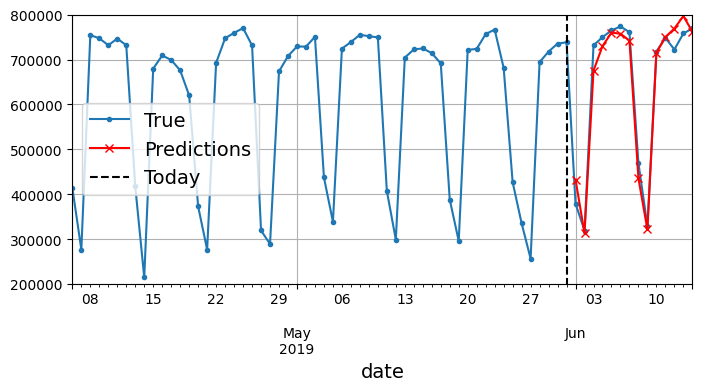

In [44]:


Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-06-01", "2019-06-14"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-04-06":"2019-06-14"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-05-31", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

In [45]:
y_valid  = rail_valid["2019-06-01":"2019-06-14"]

In [46]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, Y_pred))*1e06)
print("MAPE:", mean_absolute_percentage_error(y_valid, Y_pred) * 100)

RMSE: 29369.689901123344
MAPE: 3.8829913546604


Hmmm, no está mal, ¿no?

**Caso 2**: Predecir seq2seq

Vamos a crear una red que entrene para predecir los 14 días siguientes de una vez.  

Para ello preparamos los datos de entrada de forma que el target serán ahora los 14 días siguientes a cada instante...   

Por tanto, si nuestras secuencias tienen 56 días, ahora el target serán 56 vectores de 14 valores (ejemplo 2 del surf, pero con 56 de tamaño de secuencia y 14 de predicción)

In [47]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14, # Alargamos las secuencias
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets) # Tenemos que hacer un pequeño truco para tener los target

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [48]:
list(ahead_train_ds)[0]

(<tf.Tensor: shape=(32, 56, 5), dtype=float64, numpy=
 array([[[0.66921 , 0.689577, 1.      , 0.      , 0.      ],
         [0.487366, 0.452638, 0.      , 1.      , 0.      ],
         [0.382787, 0.515034, 0.      , 0.      , 1.      ],
         ...,
         [0.722447, 0.739143, 0.      , 0.      , 1.      ],
         [0.710743, 0.720004, 0.      , 0.      , 1.      ],
         [0.720279, 0.712077, 0.      , 0.      , 1.      ]],
 
        [[0.805911, 0.73984 , 1.      , 0.      , 0.      ],
         [0.439827, 0.405822, 0.      , 1.      , 0.      ],
         [0.336156, 0.295505, 0.      , 0.      , 1.      ],
         ...,
         [0.801986, 0.723334, 0.      , 0.      , 1.      ],
         [0.815252, 0.729419, 0.      , 0.      , 1.      ],
         [0.824632, 0.724399, 0.      , 0.      , 1.      ]],
 
        [[0.81511 , 0.779334, 0.      , 0.      , 1.      ],
         [0.847144, 0.784336, 0.      , 0.      , 1.      ],
         [0.838151, 0.777158, 1.      , 0.      , 0.      

In [49]:
list(ahead_valid_ds)[0]

(<tf.Tensor: shape=(17, 56, 5), dtype=float64, numpy=
 array([[[0.487323, 0.41414 , 0.      , 1.      , 0.      ],
         [0.331229, 0.276992, 0.      , 0.      , 1.      ],
         [0.823032, 0.754465, 0.      , 0.      , 1.      ],
         ...,
         [0.791059, 0.717681, 0.      , 0.      , 1.      ],
         [0.792091, 0.735508, 0.      , 0.      , 1.      ],
         [0.817633, 0.738322, 1.      , 0.      , 0.      ]],
 
        [[0.331229, 0.276992, 0.      , 0.      , 1.      ],
         [0.823032, 0.754465, 0.      , 0.      , 1.      ],
         [0.791556, 0.747311, 0.      , 0.      , 1.      ],
         ...,
         [0.792091, 0.735508, 0.      , 0.      , 1.      ],
         [0.817633, 0.738322, 1.      , 0.      , 0.      ],
         [0.473204, 0.379044, 0.      , 1.      , 0.      ]],
 
        [[0.823032, 0.754465, 0.      , 0.      , 1.      ],
         [0.791556, 0.747311, 0.      , 0.      , 1.      ],
         [0.760548, 0.731858, 0.      , 0.      , 1.      

In [50]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [51]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1886 - mae: 0.4779 - val_loss: 0.0186 - val_mae: 0.1547
Epoch 2/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0177 - mae: 0.1501 - val_loss: 0.0086 - val_mae: 0.1067
Epoch 3/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0115 - mae: 0.1182 - val_loss: 0.0061 - val_mae: 0.0891
Epoch 4/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0095 - mae: 0.1055 - val_loss: 0.0048 - val_mae: 0.0777
Epoch 5/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0085 - mae: 0.0977 - val_loss: 0.0039 - val_mae: 0.0689
Epoch 6/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0076 - mae: 0.0907 - val_loss: 0.0033 - val_mae: 0.0639
Epoch 7/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0072 - mae: 0.0867 - val_loss: 0.0029 - val_mae: 0.0585
Epoch 8/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0068 - mae: 0.0837 - val_loss: 0.0026 - val_mae: 0.0551
Epoch 9/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - lo

17419.079318642616

In [52]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]
Y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


array([[0.4680757 , 0.37856784, 0.725462  , 0.7699714 , 0.7656824 ,
        0.7734166 , 0.75367635, 0.49205124, 0.36637115, 0.718445  ,
        0.7590677 , 0.7758981 , 0.7795409 , 0.76950365]], dtype=float32)

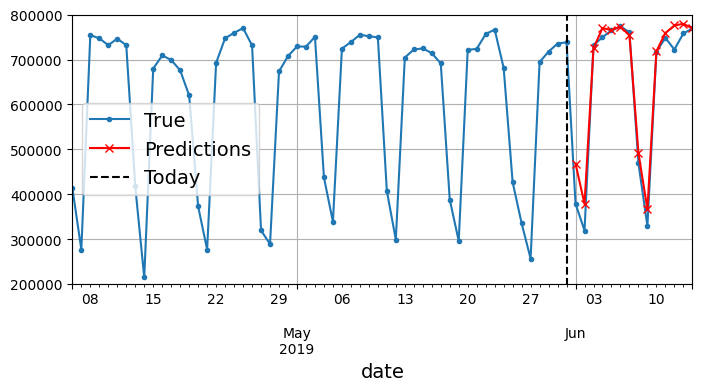

In [53]:

Y_pred = pd.Series(Y_pred[0],
                   index=pd.date_range("2019-06-01", "2019-06-14"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-04-06":"2019-06-14"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-05-31", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

In [54]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, Y_pred))*1e06)
print("MAPE:", mean_absolute_percentage_error(y_valid, Y_pred) * 100)

RMSE: 35129.93301491554
MAPE: 5.3285543231830035


Una mejora sobre el baseline aunque no sobre la predicción sobre la predicción. La mejora puede ser debida a la predicción a 14 días entrenando con secuencias de targets o bien a que hemos empleado el modelo de series multivariante. Te dejo como ejercicio el que pruebes con el modelo univariante y predicción a 14 días.b

***

Las celdas sencillas recurrentes no son las más utilizadas hoy en día, sino que existen otros dos tipos de celdas/neuronas recurrentes que buscan mejorar ese mecanismo de hipotética memoria.   

Estas dos celdas son la LSTM (Long-short term memory) que intenta regular el impacto de periodos o elementos de la secuencia más lejanos y de los más cercanos al punto tratado. Por otro lado la celda GRU (Gated Recurrent Unit), simplifica la anterior pero también intentando regular el impacto de los diferentes elementos de la secuencia.

# LSTMs

Las celdas LSTM (Long-Short Term Memory), buscan aumentar la capacidad de "memoria". Para ello ahora además de un hidden_state, devuelven un c_state en lo que vendría a ser hidden_state -> memoria a corto plazo, c_state -> memoria a largo plazo.

Para nosotros se quedan en caja negra que funcionan mejor que las neuronas recurrentes tradicionales :-), aún así os dejo aquí el esquema de una LSTM por si a alguien le pica el gusanillo:

![imagen](data/foto2.png)


https://www.turing.com/kb/comprehensive-guide-to-lstm-rnn

Por otro lado, las celdas LSTM se pueden incorpar como tal o usando una capa especial LSTM.

In [55]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32,  input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [56]:
#fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
 #                learning_rate=0.1, epochs=5)
fit_and_evaluate(lstm_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.1, epochs = 500)

Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0902 - mae: 0.3365 - val_loss: 0.0154 - val_mae: 0.1664
Epoch 2/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0171 - mae: 0.1624 - val_loss: 0.0127 - val_mae: 0.1426
Epoch 3/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0156 - mae: 0.1531 - val_loss: 0.0117 - val_mae: 0.1366
Epoch 4/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0145 - mae: 0.1474 - val_loss: 0.0109 - val_mae: 0.1300
Epoch 5/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0139 - mae: 0.1428 - val_loss: 0.0100 - val_mae: 0.1216
Epoch 6/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0133 - mae: 0.1386 - val_loss: 0.0096 - val_mae: 0.1209
Epoch 7/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0125 - mae: 0.1331 - val_loss: 0.0090 - val_mae: 0.1151
Epoch 8/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0119 - mae: 0.1290 - val_loss: 0.0085 - val_mae: 0.1108
Epoch 9/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - lo

21727.755665779114

In [57]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = lstm_model.predict(X)  # shape [1, 14]
Y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


array([[0.4412185 , 0.33695048, 0.71170604, 0.7685761 , 0.7768878 ,
        0.76305515, 0.76804864, 0.4600945 , 0.34169933, 0.71429354,
        0.77290016, 0.7773856 , 0.76407456, 0.7726666 ]], dtype=float32)

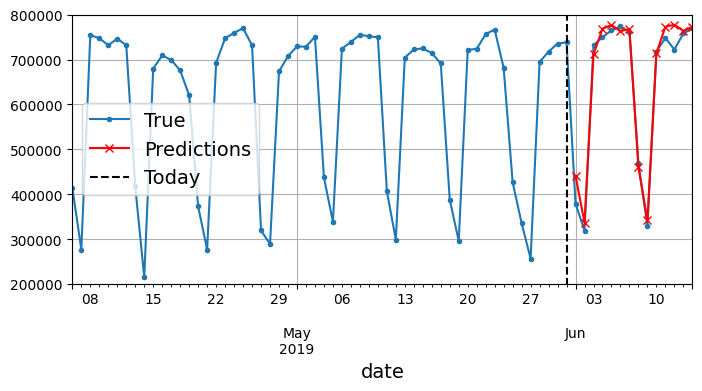

In [58]:

Y_pred = pd.Series(Y_pred[0],
                   index=pd.date_range("2019-06-01", "2019-06-14"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-04-06":"2019-06-14"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-05-31", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

In [59]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, Y_pred))*1e06)
print("MAPE:", mean_absolute_percentage_error(y_valid, Y_pred) * 100)

RMSE: 25594.51886719867
MAPE: 3.526520287664471


# GRUs

Las celdas GRU (Gated Recurrent Unit) son una "simplificación" de las LSTM, que intenta conseguir lo mismo, aumentar la memoria, pero simplificando algunos elementos. De hecho esta celda sólo tiene un hidden_state.

Os dejo el esquema y la referencia:

![imagen](data/foto3.png)

http://primo.ai/index.php?title=Gated_Recurrent_Unit_%28GRU%29

Las LSTM y las GRU son mucho más efectivas que las simples RNN y son las que se usan hoy en día. Como las LSTM, las GRU tienen su propia capa aunque puedes utilizarlas como celdas en una RNN layer (no en una SimpleRNN) y el funcionamiento es similar.


In [60]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

In [61]:
fit_and_evaluate(gru_model, train_ds, valid_ds, learning_rate=0.1, epochs=500)

Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0842 - mae: 0.3296 - val_loss: 0.0153 - val_mae: 0.1706
Epoch 2/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0171 - mae: 0.1664 - val_loss: 0.0144 - val_mae: 0.1588
Epoch 3/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0162 - mae: 0.1622 - val_loss: 0.0143 - val_mae: 0.1541
Epoch 4/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0166 - mae: 0.1612 - val_loss: 0.0145 - val_mae: 0.1474
Epoch 5/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0164 - mae: 0.1613 - val_loss: 0.0158 - val_mae: 0.1355
Epoch 6/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0181 - mae: 0.1640 - val_loss: 0.0140 - val_mae: 0.1502
Epoch 7/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0158 - mae: 0.1596 - val_loss: 0.0142 - val_mae: 0.1628
Epoch 8/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0168 - mae: 0.1640 - val_loss: 0.0138 - val_mae: 0.1424
Epoch 9/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - lo

22065.920755267143

In [62]:

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]

In [63]:
for step_ahead in range(14):
    y_pred_one = gru_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


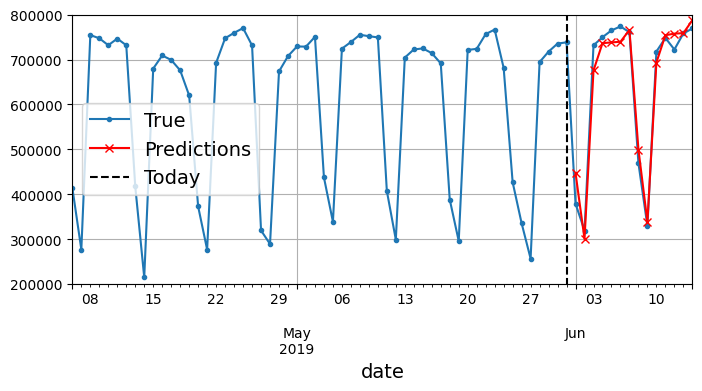

In [64]:


Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-06-01", "2019-06-14"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-04-06":"2019-06-14"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-05-31", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

In [65]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, Y_pred))*1e06)
print("MAPE:", mean_absolute_percentage_error(y_valid, Y_pred) * 100)

RMSE: 30963.415853938503
MAPE: 4.478612127913425
